In [1]:
import numpy as np
import networkx as nx
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import os

### Chargement des données

In [2]:
with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)
training_set = [element[0].split(" ") for element in training_set]

### Récupération des IDs

In [3]:
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]
print(len(IDs))

27770


### Récupération des noms d'auteurs
Retrait des parenthèses et des espaces/virgules finales

In [151]:
import re
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)
IDs2 = list()
i=0
for element in node_info:
    drap = 1
    temp = re.sub('[!@#<>\\/\'1\}\{$]', '', element[3])
    temp = re.sub('\.', ' ', element[3])

    

    while drap ==1:
        idx_parenthese_ouverte = temp.find("(")
        idx_parenthese_fermee = temp.find(")")
        if idx_parenthese_ouverte != -1 and idx_parenthese_fermee != -1:
            idx_ouvert2 = temp[(idx_parenthese_ouverte+1):idx_parenthese_fermee].find("(")
            if idx_ouvert2 ==-1:
                temp = temp[0:(idx_parenthese_ouverte-1)]+temp[(idx_parenthese_fermee+1):]
            else:
                drap2=1
                idx_ouvert_temp = idx_parenthese_ouverte+1
                while drap2 ==1:
                    idx_ouvert_temp += idx_ouvert2
                    idx_ouvert2 = temp[(idx_ouvert_temp+1):idx_parenthese_fermee].find("(")
                    if idx_ouvert2==-1:
                        temp = temp[0:(idx_ouvert_temp)]+temp[(idx_parenthese_fermee+1):]
                        drap2=0
        elif idx_parenthese_ouverte != -1:
            temp = temp[0:(idx_parenthese_ouverte-1)]
        elif idx_parenthese_fermee != -1:
            temp = temp[(idx_parenthese_fermee+1):]
        elif len(temp) >1 and temp[-1]==' ':
            temp=temp[0:-1]
        elif len(temp) >1 and temp[-1]==',':
            temp=temp[0:-1]
        elif len(temp) >1 and temp[-1]=='.':
            temp=temp[0:-1]
        else :
            idx_point = temp.find(".")
            if idx_point == -1:
                drap = 0
            elif temp[idx_point+1]!=" ":
                temp=temp[0:idx_point] + ". "+ temp[(idx_point+1):]
            else:
                drap = 0

    tempsplit = temp.split(", ")
    for j in range(len(tempsplit)-1,0,-1):
        if tempsplit[j]=='':
            del(tempsplit[j])
    i+=1

    if np.mod(i,5000)==0:
        print(i)
    IDs2.append(tempsplit)

5000
10000
15000
20000
25000


### Formatage des noms
On ne garde que l'initiale et le dernier mot (qui fait office de nom)

In [160]:
res = list()
n_erreur=0
n_erreur2=0
for i in range(len(IDs2)):
    drap = 0
    temp_list = list()
    for j in range(len(IDs2[i])):
        # On récupère l'initiale et le dernier mot si c'est possible
        # Si impossible on sort des deux boucles et on ne rajoute pas le papier ?
        idx_parenthese_ouverte = IDs2[i][j].find("(")
        idx_parenthese_fermee = IDs2[i][j].find(")")
        if idx_parenthese_ouverte != -1 and idx_parenthese_fermee != -1:
            print("erreur type 1")
            IDs_ij = IDs2[i][j][0:(idx_parenthese_ouverte-1)]+IDs2[i][j][(idx_parenthese_fermee+2):]
            print(IDs2[i][j], IDs_ij)
        elif idx_parenthese_ouverte != -1:
            print("erreur type 2")
            IDs_ij = IDs2[i][j][0:(idx_parenthese_ouverte-1)]
            print(IDs2[i][j])
            print(IDs_ij)
        elif idx_parenthese_fermee != -1:
            print("erreur type 3")
            IDs_ij = IDs2[i][j][(idx_parenthese_fermee+2):]
            print(IDs2[i][j])
            print(IDs_ij)
        else : 
            IDs_ij = IDs2[i][j]
        temp = IDs_ij.split(" ")
        #print(temp)
        if temp==[""]:
            drap = 2
            break
        if temp[-1] == "" or temp[-1][0].isupper() == False:
            drap = 1
            break
        else:
            temp_list.append(temp[0][0].upper() + ". " + temp[-1])
    
    if drap == 0:
        res.append(temp_list)
    elif drap==1:
        res.append(None)
        n_erreur+=1
    else:
        res.append(None)
        n_erreur2+=1
        
print("Erreur 1 (nom bizarre) : ", n_erreur, "Erreur 2 (pas de nom) : ", n_erreur2)


Erreur 1 (nom bizarre) :  802 Erreur 2 (pas de nom) :  4033


In [157]:
len(res)

27770

## Stockage du fichier avec les noms corrigés et séparés (potentiellement inutile)

In [89]:
fo = open('node_info_rectified.csv','w')
writer = csv.writer(fo,  lineterminator = '\n')
i=0
f = open("node_information.csv", "r")
reader = csv.reader(f)

for row in reader:
    row[3] = res[i]
    writer.writerow(row)
    i+=1

fo.close()
f.close()

On selectionne les couples d'articles qui sont liés

In [37]:
couple_article = [ [id1,id2] for id1, id2, edge in training_set if int(edge) == 1 ] 
list_couple_article_without_edge = [ [id1,id2] for id1, id2, edge in training_set if int(edge) ==0 ] 

In [7]:
len(couple_article)

335130

### Création d'un dictionnaire des citations entre auteurs et des coauteurs

In [90]:
dict_id_coauthor = {}
dict_id_coauthor_strict = {}
list_coauthor = list()
for i in res:
    if i != None:
        for j in i:
            for k in i:
                    dict_id_coauthor[j]=k
                    if j != k:
                        dict_id_coauthor_strict[j]=k
                        list_coauthor.append(list([j, k]))
                    

In [137]:
G.clear()

## Création du graphe d'article

In [138]:
graph_article = nx.Graph(couple_article)
G=graph_article
#add isolated nodes
G.add_nodes_from(IDs)

### Ajout de l'attribut "auteur" à chaque noeud

In [140]:
for i in range(len(node_info)):
    if G.has_node(node_info[i][0]):
        G.node[node_info[i][0]]['author'] = res[i]

In [139]:
Graph_coauthor.clear()

## Création du graphe d'auteur (arrêtes : cocitation)

In [141]:
Graph_author = nx.Graph()
for node, data in G.nodes_iter(data=True):
    if data['author'] != None:
        for author in data['author']:
            Graph_author.add_node(author)

In [127]:
G.node['1002']

{'author': ['M. Cvetic', 'H. Lu', 'C. Pope']}

In [142]:
for edge in G.edges_iter():
    if G.node[edge[0]]['author'] != None and G.node[edge[1]]['author'] != None:
        for author_from in G.node[edge[0]]['author']:
            for author_to in G.node[edge[1]]['author']:
                Graph_author.add_edge(author_from,author_to)

In [146]:
Graph_coauthor.edge['A. Kempf']

{'G. Mangano': {}, 'S. Adler': {}}

## Création du graphe de coateurs (arrêtes : corédaction)

In [144]:
Graph_coauthor = nx.Graph()
for node, data in G.nodes_iter(data=True):
    if data['author'] != None:
        for author in data['author']:
            Graph_coauthor.add_node(author)

In [145]:
for node, data in G.nodes_iter(data=True):
    if data['author'] != None:
        for author1 in data['author']:
            for author2 in data['author']:
                if author1 != author2:
                    Graph_coauthor.add_edge(author1,author2)

### Calcul des plus courts chemins (inutile ?)

In [322]:
shortest_path=[]
i=0
for node1, node2, edge in training_set:
    if nx.has_path(G=G,source=node1, target=node2):
        shortest_path.append(nx.shortest_path_length(G,node1,node2))
    else:
        shortest_path.append(50)
    i+=1
    if np.mod(i,100000)==0:
        print(i)

100000
200000
300000
400000
500000
600000


In [341]:
isedge = []
for i in range(len(training_set)):
    if int(training_set[i][2])==1:
        isedge.append("r")
    else:
        isedge.append("g")

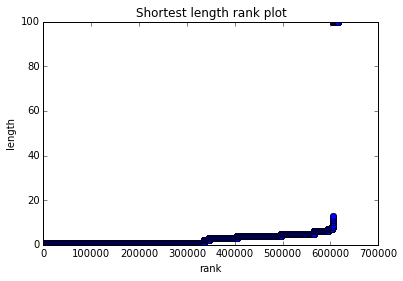

In [342]:
shortest_length_sequence=sorted(shortest_path) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(shortest_length_sequence)

plt.plot(shortest_length_sequence, ls='b-',color=isedge,marker='o')
plt.title("Shortest length rank plot")
plt.ylabel("length")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45,0.45,0.45,0.45])

plt.axis('off')

plt.savefig("shortest_length_histogram.png")
plt.show()

## Calcul des plus courts chemins (graphe d'auteur)

In [368]:
min_shortest_path_author=[]
i=0
for node1, node2, edge in training_set:
    temp=[]
    if G.node[node1]['author']==None or G.node[node2]['author']==None:
        min_shortest_path_author.append(1000)
    else:
        for author1 in G.node[node1]['author']:
            for author2 in G.node[node2]['author']:
                if nx.has_path(G=Graph_author,source=author1, target=author2):
                    temp.append(nx.shortest_path_length(G=Graph_author,source=author1, target=author2))
    if len(temp) != 0:
        min_shortest_path_author.append(min(temp))
    else:
        min_shortest_path_author.append(2000)
                    
    i+=1
    if np.mod(i,100000)==0:
        print(i)

100000
200000
300000
400000
500000
600000


In [420]:
np.percentile(min_shortest_path_author, q=76.0069)

2000.0

In [391]:
np.percentile(min_shortest_path_author, q=52.4134)

203.58930799225345

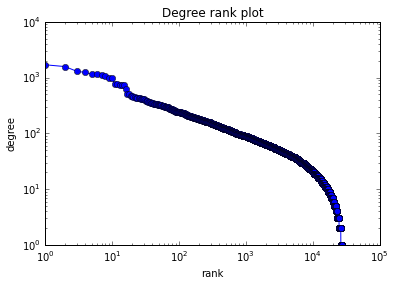

In [301]:
import networkx as nx
import matplotlib.pyplot as plt

degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45,0.45,0.45,0.45])

plt.axis('off')

plt.savefig("degree_histogram.png")
plt.show()

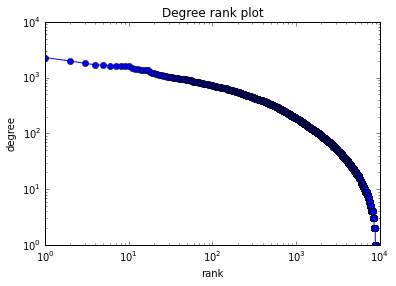

In [302]:
import networkx as nx
import matplotlib.pyplot as plt

degree_sequence=sorted(nx.degree(Graph_author).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45,0.45,0.45,0.45])

plt.axis('off')

plt.savefig("degree_histogram.png")
plt.show()

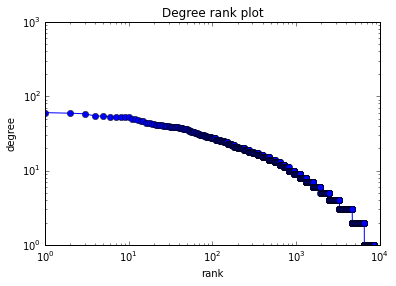

In [303]:
import networkx as nx
import matplotlib.pyplot as plt

degree_sequence=sorted(nx.degree(Graph_coauthor).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45,0.45,0.45,0.45])

plt.axis('off')

plt.savefig("degree_histogram.png")
plt.show()